In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#!pip install pygam
#from pygam import LinearGAM

In [20]:
# load in dataset
# read in UK t2m & NAO data
df = pd.read_csv("ERA5_hourly_UK.csv")
df.columns = ["date_time","t2m","ssrd","msl","nao", "w10","w100"]
df.head()

,date_time,t2m,ssrd,msl,nao,w10,w100
0,1979-01-01 00:00:00,-5.702784,-32767.0,1014.010319,-1.38,0.539450,1.686726
1,1979-01-01 01:00:00,-5.507162,-32767.0,1014.724101,-1.38,0.756348,1.752340
2,1979-01-01 02:00:00,-5.664224,-32767.0,1015.209416,-1.38,1.106655,2.131312
3,1979-01-01 03:00:00,-5.944852,-32767.0,1015.758926,-1.38,1.299900,2.487398
4,1979-01-01 04:00:00,-5.952020,-32767.0,1015.954954,-1.38,1.383135,2.694151


In [21]:
# add week
df["week"] = pd.to_numeric(pd.to_datetime(df.date_time).dt.strftime("%U"))

# Preprocessing

### Split Train/test

In [45]:
# calculate daily values
df.date_time = pd.to_datetime(df.date_time)
df_daily = df.groupby(df.date_time.dt.date).mean()
df_daily["t2mmax"] = t2mmax = df.t2m.groupby(df.date_time.dt.date).max()
df_daily["t2mmin"] = df.t2m.groupby(df.date_time.dt.date).min()


# set X equal to df_daily
X = df_daily
print(X)

                  t2m         ssrd          msl   nao       w10       w100  \
date_time                                                                    
1979-01-01  -4.159642 -9531.855820  1018.727490 -1.38  1.642102   3.302241   
1979-01-02  -1.011778    25.708586  1022.629712 -1.38  2.915822   4.989152   
1979-01-03  -0.129076    25.569494  1013.880059 -1.38  4.747445   7.739491   
1979-01-04  -0.641538    20.183029  1011.304354 -1.38  3.155913   5.060900   
1979-01-05  -2.196899    25.340972  1021.575488 -1.38  2.858333   4.329928   
1979-01-06   2.164684    19.788885  1017.571954 -1.38  5.573352   8.956061   
1979-01-07   5.304816    14.263631  1014.640871 -1.38  7.295695  11.353056   
1979-01-08   3.400665    22.650495  1012.027946 -1.38  5.293081   8.256520   
1979-01-09   1.530394    28.676082  1004.155543 -1.38  5.162770   8.119932   
1979-01-10   0.817920    25.774781   983.719321 -1.38  3.710019   5.971083   
1979-01-11   0.691022    32.843934   991.373527 -1.38  4.742458 

In [46]:
# create 24-hour w10 arrays as target variable
Y_list = []
for i in range(int(len(df)/24)):
    Y_list.append(df.w10.iloc[(i*24):(i*24+24)].values)
Y = np.array(Y_list)

# add date_time index
y = pd.DataFrame(Y,index=df_daily.index)



### Visualization of independent vars

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1f6925470>,
      dtype=object)

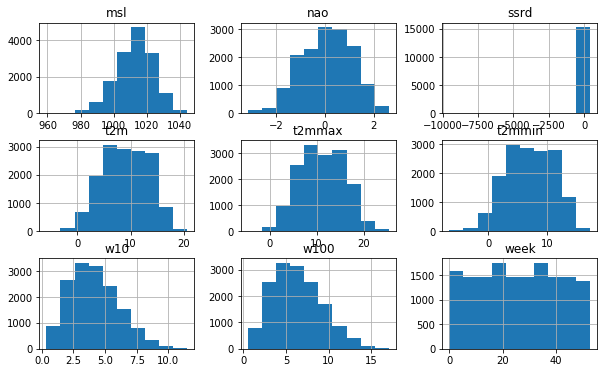

In [47]:
X.hist(figsize=(10,6))

Mostly normal distributions of variables of interest, except ssrd. 

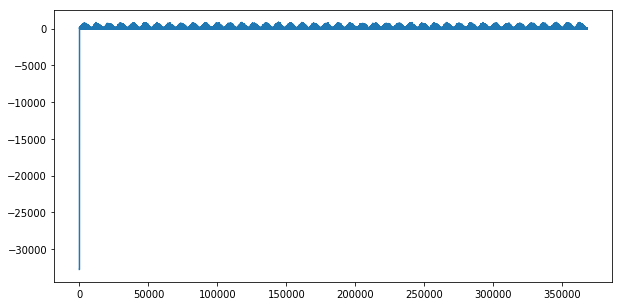

In [48]:
df.ssrd.plot(figsize=(10,5))

Remove outlier from ssrd.

/opt/jaspy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


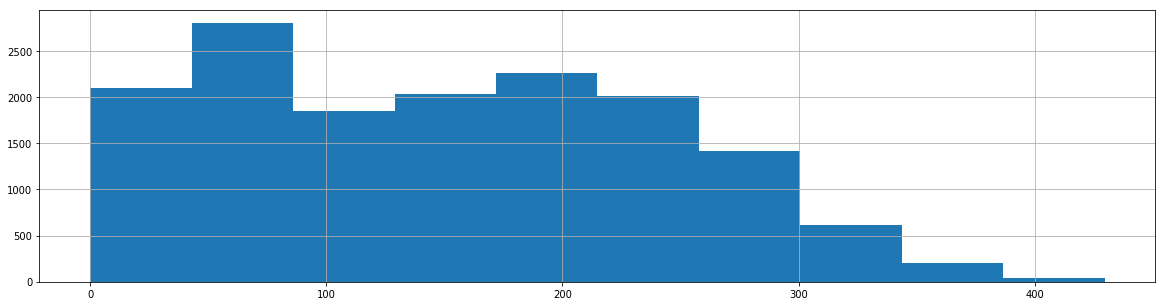

In [49]:
# remove outliers
X.ssrd[X.ssrd<-5000]=0

# produce ssrd plot
X.ssrd.hist()

Split train/test

In [50]:
# split train/test 70/30
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state = 10,shuffle=False)

# create a dataframe of the hours for plotting purposes
X_test.index = pd.to_datetime(X_test.index)
X_test_hours = X_test.resample("1H").pad().index

### Modeling

Linear Regression

In [51]:
from sklearn.linear_model import LinearRegression

# produce linear regression
reg = LinearRegression().fit(X_train, y_train)
pred_reg = reg.predict(X_test)

In [52]:
# metrics
r2_reg = r2_score(y_test,pred_reg)
mae_reg = mean_absolute_error(y_test,pred_reg)
mse_reg = mean_squared_error(y_test,pred_reg)

print("R2-score: ",r2_reg)
print("MAE-score: ",mae_reg)



R2-score:  0.8506511647521527
MAE-score:  0.5884476719454261


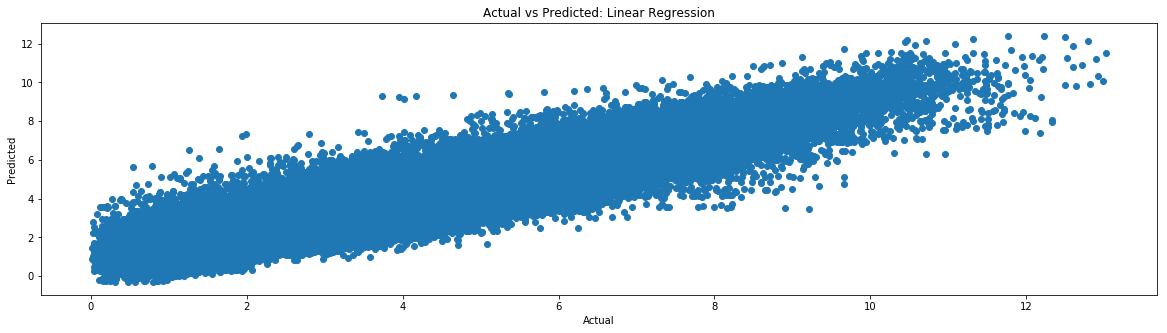

In [53]:
# plot results
plt.scatter(y_test.values.flatten(),pred_reg.flatten())
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: Linear Regression")
plt.rcParams["figure.figsize"] = (20,5)

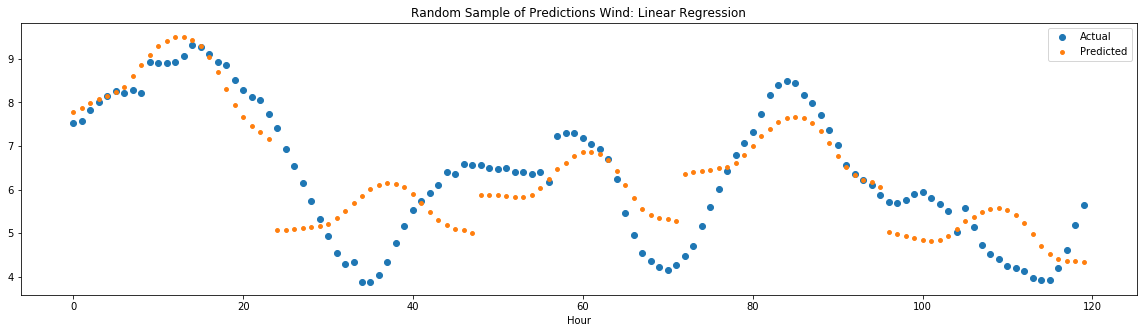

In [101]:
plt.scatter(np.arange(0,5*24,1),y_test.values[300:305])
plt.scatter(np.arange(0,5*24,1),pred_reg[300:305], s = 15)
plt.xlabel("Hour")
plt.title("Random Sample of Predictions Wind: Linear Regression")
plt.legend(["Actual","Predicted"])

# Random Forest

In [55]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=60).fit(X_train,y_train)
pred_rf = rf.predict(X_test)

In [56]:
# metrics
r2_rf = r2_score(y_test,pred_rf)
mae_rf = mean_absolute_error(y_test,pred_rf)
mse_rf = mean_squared_error(y_test,pred_rf)

print("R2-score: ",r2_rf)
print("MAE-score: ",mae_rf)
print("MSE-score: ",mse_rf)


R2-score:  0.844469919633761
MAE-score:  0.59742838981022
MSE-score:  0.6609881614438006


Text(0, 0.5, 'MSE')

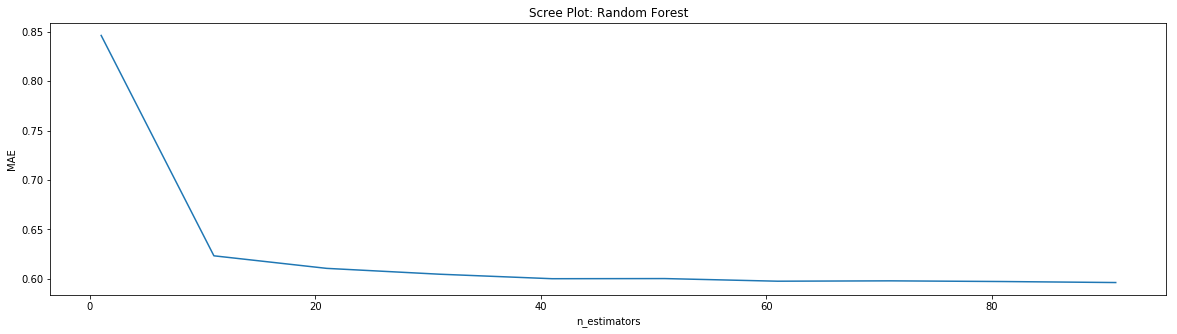

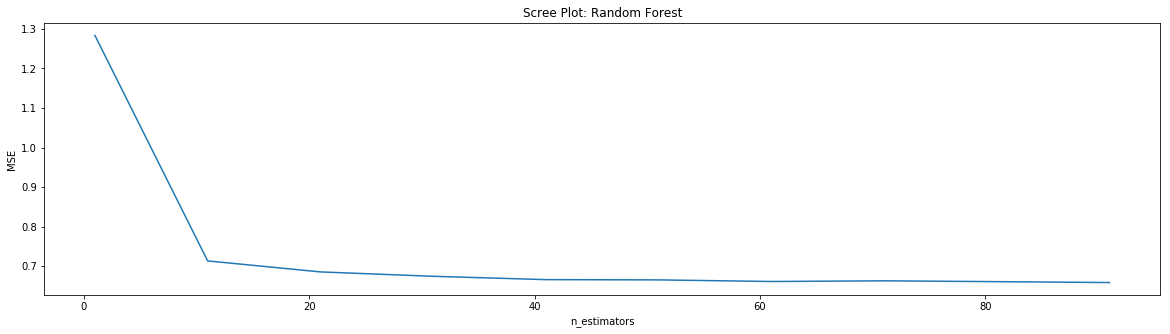

In [57]:
n_estimators = []
mae = []
mse = []
for i in range(1,100,10):
    rf = RandomForestRegressor(n_estimators=i).fit(X_train,y_train)
    pred_rf = rf.predict(X_test)
    n_estimators.append(i)
    mae.append(mean_absolute_error(y_test,pred_rf)) 
    mse.append(mean_squared_error(y_test,pred_rf)) 
n_estimators = np.array(n_estimators)
mae = np.array(mae)
mse = np.array(mse)

figure = plt.figure()
plt.plot(n_estimators,mae)
plt.title("Scree Plot: Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("MAE")

figure = plt.figure()
plt.plot(n_estimators,mse)
plt.title("Scree Plot: Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("MSE")

Maximum number of trees can be set to 100 as there is little computational cost.

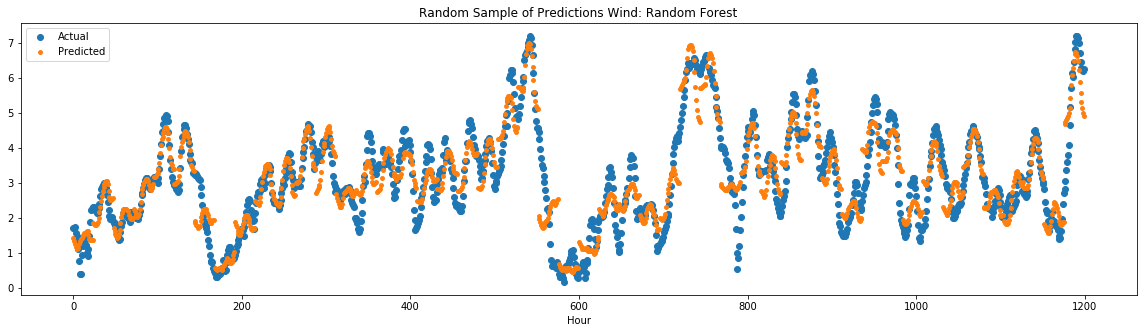

In [78]:
plt.scatter(np.arange(0,50*24,1),y_test.values[4000:4050])
plt.scatter(np.arange(0,50*24,1),pred_rf[4000:4050], s = 15)
plt.xlabel("Hour")
plt.title("Random Sample of Predictions Wind: Random Forest")
plt.legend(["Actual","Predicted"])

### Gradient Boosted Trees

In [59]:
from sklearn.ensemble import RandomForestRegressor

gbt = RandomForestRegressor(n_estimators=100).fit(X_train,y_train)
pred_gbt = gbt.predict(X_test)

In [60]:
# metrics
r2_gbt = r2_score(y_test,pred_gbt)
mae_gbt = mean_absolute_error(y_test,pred_gbt)

print("R2-score: ",r2_gbt)
print("MAE-score: ",mae_gbt)

R2-score:  0.8448390336745778
MAE-score:  0.5963795021118271


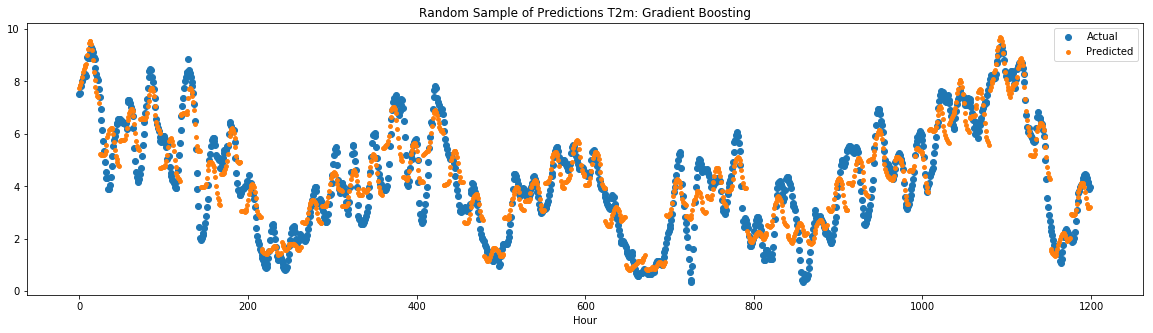

In [76]:
plt.scatter(np.arange(0,50*24,1),y_test.values[300:350])
plt.scatter(np.arange(0,50*24,1),pred_gbt[300:350], s=15)
plt.xlabel("Hour")
plt.title("Random Sample of Predictions T2m: Gradient Boosting")
plt.legend(["Actual","Predicted"])

### Neural Networks

In [85]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes=(50, 30, 30, 24), activation='relu', solver='adam', alpha=0.001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001).fit(X_train,y_train)
pred_nn = nn.predict(X_test)

In [86]:
# metrics
r2_nn = r2_score(y_test,pred_nn)
mae_nn = mean_absolute_error(y_test,pred_nn)
mse_nn = mean_squared_error(y_test,pred_nn)

print("R2-score: ",r2_nn)
print("MAE-score: ",mae_nn)
print("MSE-score: ",mse_nn)

R2-score:  0.8401416644010657
MAE-score:  0.6107572311921957
MSE-score:  0.6798663804264581


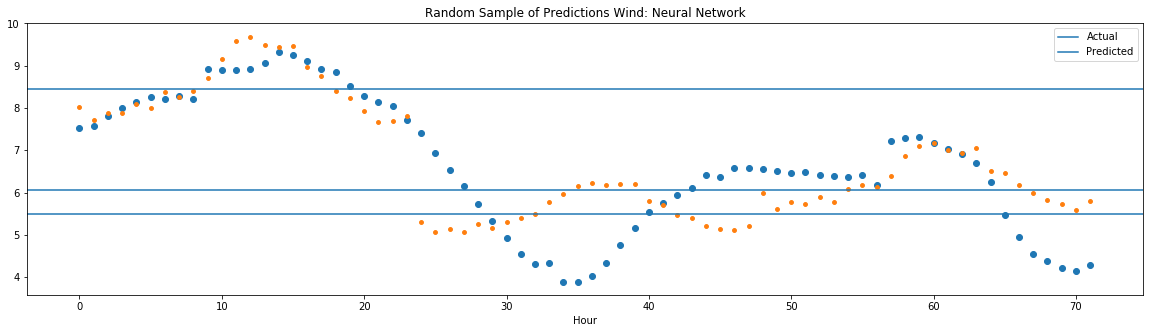

In [100]:
plt.scatter(np.arange(0,3*24,1),y_test.values[300:303])
plt.scatter(np.arange(0,3*24,1),pred_nn[300:303], s=15)
plt.axhline(X_test["w10"].values[300])
plt.axhline(X_test["w10"].values[301])
plt.axhline(X_test["w10"].values[302])

plt.xlabel("Hour")
plt.title("Random Sample of Predictions Wind: Neural Network")
plt.legend(["Actual","Predicted"])

### Analyze Best Performer

The best performer was Gradient Boosting. 

Below is a visual representation of the seasonal error.

Text(0, 0.5, 'MSE')

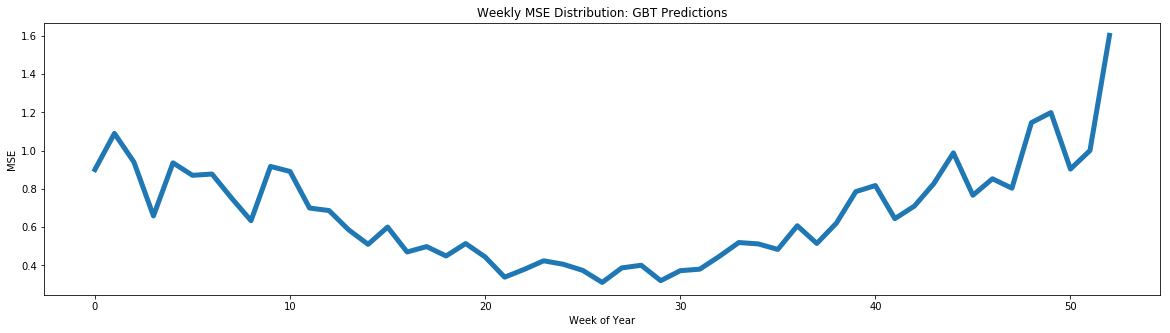

In [62]:
se = (pred_gbt - y_test)**2
se.index = pd.to_datetime(se.index)
mse_by_week = se.groupby(se.index.week).mean().mean(axis=1)
plt.plot(np.arange(0,53,1),mse_by_week.values.flatten(),linewidth=5)
plt.title("Weekly MSE Distribution: GBT Predictions")
plt.xlabel("Week of Year")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

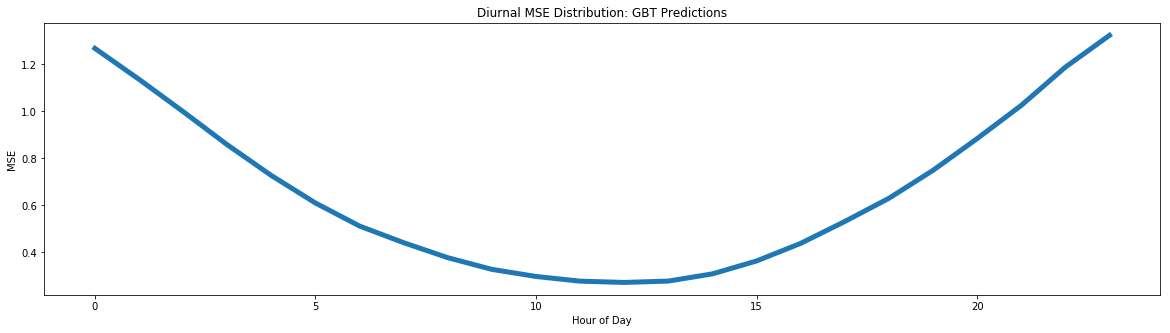

In [63]:
se = (pred_gbt - y_test)**2
se.index = pd.to_datetime(se.index)
mse_by_hour = se.groupby(se.index.hour).mean()
plt.plot(np.arange(0,24,1),mse_by_hour.values.flatten(),linewidth=5)
plt.title("Diurnal MSE Distribution: GBT Predictions")
plt.xlabel("Hour of Day")
plt.ylabel("MSE")

Found that winter weeks have higher MSE in comparison to summer months.

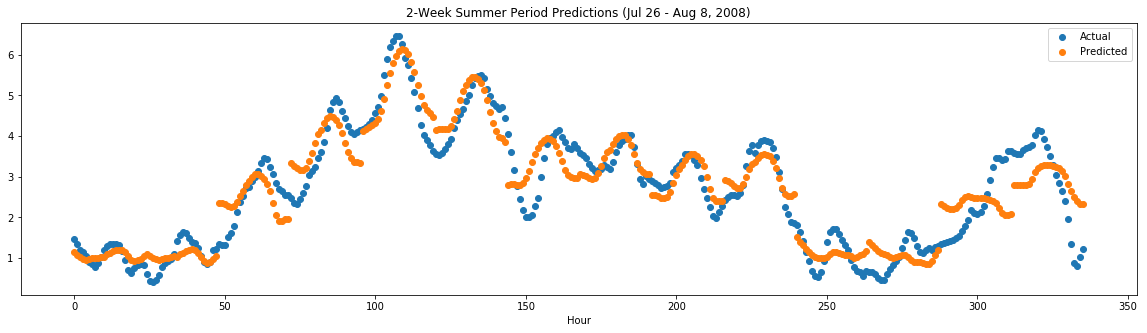

In [64]:
# generate summer/winter comparisons
y_d14_summer = y_test.iloc[60:74]
y_d14_winter = y_test.iloc[230:244]
pred_d14_summer = pred_gbt[60:74]
pred_d14_winter = pred_gbt[230:244]

plt.scatter(np.arange(0,14*24,1),y_d14_summer)
plt.scatter(np.arange(0,14*24,1),pred_d14_summer)
plt.xlabel("Hour")
plt.title("2-Week Summer Period Predictions (Jul 26 - Aug 8, 2008)")
plt.legend(["Actual","Predicted"])

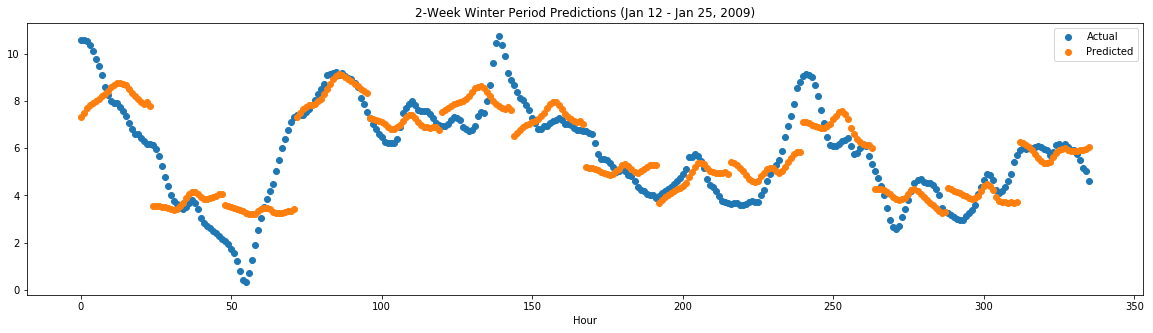

In [65]:
plt.scatter(np.arange(0,14*24,1),y_d14_winter)
plt.scatter(np.arange(0,14*24,1),pred_d14_winter)
plt.xlabel("Hour")
plt.title("2-Week Winter Period Predictions (Jan 12 - Jan 25, 2009)")
plt.legend(["Actual","Predicted"])

Clearly the model has issues with the extreme fluctuations of temperatures across the UK in the winter months, with predictions unable to capture the variability of the diurnal cycle. Summer months exhibit a more constant diurnal cycle with much better predictions.